# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
import cv2
import matplotlib
import matplotlib.pyplot as plt                        
%matplotlib inline
print(torch.__version__)
torch.manual_seed(17)

0.4.0


In [2]:
## Specify appropriate transforms, and batch_sizes
Img_size  = 256
Crop_size = 224
Final_Image_Size = Crop_size
mean_start = [0.485, 0.456, 0.406]
std_start  = [0.229, 0.224, 0.225]
transform_dir = {
    'train':  transforms.Compose([
        transforms.Resize([Img_size, Img_size]), 
        transforms.RandomCrop(Crop_size),
        transforms.RandomHorizontalFlip(p=0.1),  
        transforms.RandomVerticalFlip(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean_start,std_start)]) 
    ,    
    'test': transforms.Compose([
        transforms.Resize([Crop_size, Crop_size]),        
        transforms.ToTensor(),
        transforms.Normalize(mean_start,std_start)]) 
}

### TODO: Write data loaders for training, validation, and test sets
data_dir = "/home/workspace/nd101-c2-landmarks-starter/landmark_project/landmark_images/"
All_data   = datasets.ImageFolder(data_dir + 'train', transform = transform_dir['train'])
test_data  = datasets.ImageFolder(data_dir + 'test' , transform = transform_dir['test'])

batch_size = 128
num_workers = 0
valid_size = 0.25

Valid_size = int(len(All_data)*valid_size)
Class_to_id = All_data.class_to_idx
Total_Class = len(Class_to_id)
#Reversing the mapping : Index: CLass label
idx2class = {v: k for k, v in All_data.class_to_idx.items()}

num_train = len(All_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(All_data , batch_size=batch_size, shuffle=False,  sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(All_data , batch_size=batch_size, shuffle=False,  sampler=valid_sampler, num_workers=num_workers)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False,                         num_workers=num_workers)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}
print('Size of Training dataset:{}\nSize of Validation dataset:{}\nSize of Testing dataset:{}\n'.format(len(train_idx), len(valid_idx), len(test_loader.dataset)))

Size of Training dataset:3747
Size of Validation dataset:1249
Size of Testing dataset:1250



**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1.  In my analysis, I first resize the image to a size of (256, 256) followed by a random crop of size (224,224). I looked at the image size used by existing CNN architectures such as VGG, resnet, etc., and found that they all use a size of (224, 224).  Hence, I first resize my image of (256, 256) so that I have some space left for cropping with the required size. 
2. Yes, I did data augmentation. In particular, I used random crop, horizonal and vertical flip. I decided not to add rotation to keep the training time to be minimal. 


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

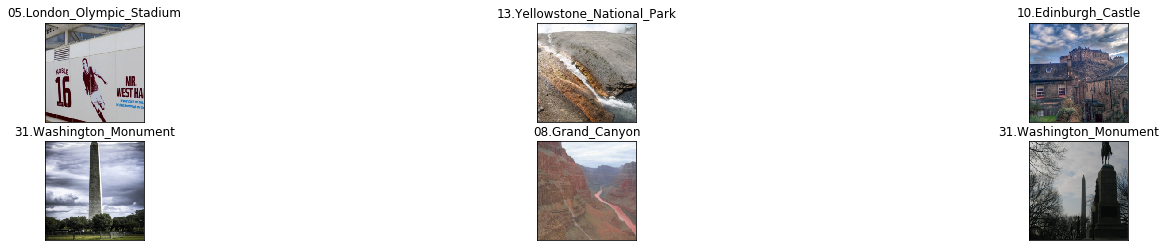

In [16]:
def imshow(img):
    mean = np.array(mean_start)
    std = np.array(std_start)
    img = img*std[:,None,None] + mean[:,None,None]  # unnormalize (z,x,y)
    img = np.transpose(img, (1, 2, 0)) # (x,y,z)
    for i in range(3):
        temp = img[:,:,i]
        temp = np.clip(temp,0,1)
        img[:,:,i] = temp
    
    plt.imshow(img)  # convert from Tensor image

## TODO: visualize a batch of the train data loader
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
labels = labels.numpy()
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(6):
    ax = fig.add_subplot(2, 6/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(idx2class[labels[idx]])



### Initialize use_cuda variable

In [8]:
# useful variable that tells us whether we should use the GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model,option):
    if(option == 'SGD'):
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    return optimizer   

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [23]:
import torch.nn as nn
Leaky_Relu = 0
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self,LRelu):
        super(Net, self).__init__()
        Num_Filter = 16
        num_layer  = 0
        self.activation_type = LRelu
        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        num_layer += 1
        # convolutional layer (sees 128x128x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        num_layer += 1
        # convolutional layer (sees 64x64x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        num_layer += 1
        # convolutional layer (sees 32x32x64 tensor)
        #self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.Final_size = int((Num_Filter*2**(num_layer-1))*(Final_Image_Size/2**(num_layer))*(Final_Image_Size/2**(num_layer)))
        # linear layer (sees 32x32x64 tensor)
        self.fc1 = nn.Linear(self.Final_size, 300)
        self.fc2 = nn.Linear(300, 400)
        self.fc3 = nn.Linear(400, Total_Class)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.20)

       
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        if(self.activation_type):
            x = self.pool(F.leaky_relu(self.conv1(x),negative_slope=0.1))
            x = self.pool(F.leaky_relu(self.conv2(x),negative_slope=0.1))
            x = self.pool(F.leaky_relu(self.conv3(x),negative_slope=0.1))
            #x = self.pool(F.leaky_relu(self.conv4(x),negative_slope=0.1))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            #x = self.pool(F.relu(self.conv4(x)))

        # flatten image input with dimension (1,(64 * 32 * 32))
        x = x.view(-1, self.Final_size)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        if(self.activation_type):
            x = F.leaky_relu(self.fc1(x),negative_slope=0.1)
        else:
            x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        if(self.activation_type):
            x = F.leaky_relu(self.fc2(x),negative_slope=0.1)
        else:
            x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)
        return x       
       

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net(Leaky_Relu)
print(model_scratch)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model_scratch.cuda()

    

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=50, bias=True)
  (dropout): Dropout(p=0.2)
)


In [13]:
# Checking in and out channels
print(model_scratch.conv1.in_channels)
print(model_scratch.conv1.out_channels)

3
16


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I decided to keep three convolution layers with a starting depth of 16. The depth increases by a factor of 2 for each CNN layers. The decision to keep three layers was partly based on computational resources. I noticed that the CUDA seems to run out of memory with four CNN layers. For the densely connected layers, I choose one input, one hidden and one output layer with 300 and 400 nodes. The decision to use 300 and 400 nodes was based on past experience with neural networks.  

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [5]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
                
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
           

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))

        
       

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        

    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [27]:
#-#-# Do NOT modify the code below this line. #-#-#
Opt_values = ['SGD','Adam']
curr_optimizer = Opt_values[0]
if(curr_optimizer == 'SGD'):
    print("Optimizer : SGD")
else:
    print("Optimizer : Adam")   
#model_scratch.apply(custom_weight_init)
model_scratch.load_state_dict(torch.load('ignore.pt'))
model_scratch = train(50, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch,curr_optimizer), criterion_scratch, train_on_gpu, 'ignore.pt')

Optimizer : SGD
Epoch: 1 	Training Loss: 3.678396 	Validation Loss: 3.652841
Validation loss decreased (inf --> 3.652841).  Saving model ...
Epoch: 2 	Training Loss: 3.664438 	Validation Loss: 3.635143
Validation loss decreased (3.652841 --> 3.635143).  Saving model ...
Epoch: 3 	Training Loss: 3.638931 	Validation Loss: 3.625100
Validation loss decreased (3.635143 --> 3.625100).  Saving model ...
Epoch: 4 	Training Loss: 3.611689 	Validation Loss: 3.606889
Validation loss decreased (3.625100 --> 3.606889).  Saving model ...
Epoch: 5 	Training Loss: 3.608453 	Validation Loss: 3.605568
Validation loss decreased (3.606889 --> 3.605568).  Saving model ...
Epoch: 6 	Training Loss: 3.584378 	Validation Loss: 3.600128
Validation loss decreased (3.605568 --> 3.600128).  Saving model ...
Epoch: 7 	Training Loss: 3.556067 	Validation Loss: 3.583238
Validation loss decreased (3.600128 --> 3.583238).  Saving model ...
Epoch: 8 	Training Loss: 3.543948 	Validation Loss: 3.529864
Validation loss de

In [29]:
torch.save(model_scratch.state_dict(), 'Final_model.pt')

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [30]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20
Load_Prev = 0

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

def custom_weight_init(m):
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        lim = 1. / n
        m.weight.data.uniform_(-lim, lim)
        m.bias.data.fill_(0.1)
    elif isinstance(m, nn.Linear):
        fan_in = m.weight.data.size()[0]
        lim = 1. / np.sqrt(fan_in)
        m.weight.data.uniform_(-lim, lim)
        m.bias.data.fill_(0.1)

        # reset the model parameters
model_scratch.apply(custom_weight_init)

Opt_values = ['SGD','Adam']
curr_optimizer = Opt_values[0]
if(curr_optimizer == 'SGD'):
    print("Optimizer : SGD")
else:
    print("Optimizer : Adam")
# train the model
if(Load_Prev == 1):
    model_scratch.load_state_dict(torch.load('model_scratch.pt'))
    print("Loaded previously estimated model")

model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch,curr_optimizer), criterion_scratch, train_on_gpu, 'model_scratch.pt')

Optimizer : SGD
Epoch: 1 	Training Loss: 3.988657 	Validation Loss: 3.922771
Validation loss decreased (inf --> 3.922771).  Saving model ...
Epoch: 2 	Training Loss: 3.943253 	Validation Loss: 3.920432
Validation loss decreased (3.922771 --> 3.920432).  Saving model ...
Epoch: 3 	Training Loss: 3.931896 	Validation Loss: 3.921639
Epoch: 4 	Training Loss: 3.932059 	Validation Loss: 3.920768
Epoch: 5 	Training Loss: 3.929458 	Validation Loss: 3.921272
Epoch: 6 	Training Loss: 3.929293 	Validation Loss: 3.920465
Epoch: 7 	Training Loss: 3.923236 	Validation Loss: 3.920904
Epoch: 8 	Training Loss: 3.926601 	Validation Loss: 3.921818
Epoch: 9 	Training Loss: 3.923178 	Validation Loss: 3.921029
Epoch: 10 	Training Loss: 3.922167 	Validation Loss: 3.920329
Validation loss decreased (3.920432 --> 3.920329).  Saving model ...
Epoch: 11 	Training Loss: 3.917474 	Validation Loss: 3.918997
Validation loss decreased (3.920329 --> 3.918997).  Saving model ...
Epoch: 12 	Training Loss: 3.923822 	Vali

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [28]:
def test(model, loaders, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss/total))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('Final_model.pt'))
test(model_scratch, loaders_scratch, criterion_scratch, train_on_gpu)

Test Loss: 3.122877


Test Accuracy: 23% (291/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [5]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
Img_size  = 256
Crop_size = 224
Final_Image_Size = Crop_size
mean_start = [0.485, 0.456, 0.406]
std_start  = [0.229, 0.224, 0.225]
transform_dir = {
    'train':  transforms.Compose([
        transforms.Resize([Img_size, Img_size]), 
        transforms.RandomCrop(Crop_size),
        transforms.RandomHorizontalFlip(p=0.1),  
        transforms.RandomVerticalFlip(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean_start,std_start)]) 
    ,    
    'test': transforms.Compose([
        transforms.Resize([Crop_size, Crop_size]),        
        transforms.ToTensor(),
        transforms.Normalize(mean_start,std_start)]) 
}

### TODO: Write data loaders for training, validation, and test sets
data_dir = "/home/workspace/nd101-c2-landmarks-starter/landmark_project/landmark_images/"
All_data   = datasets.ImageFolder(data_dir + 'train', transform = transform_dir['train'])
test_data  = datasets.ImageFolder(data_dir + 'test' , transform = transform_dir['test'])

batch_size = 64
num_workers = 0
valid_size = 0.25

Valid_size = int(len(All_data)*valid_size)
Class_to_id = All_data.class_to_idx
Total_Class = len(Class_to_id)
#Reversing the mapping : Index: CLass label
idx2class = {v: k for k, v in All_data.class_to_idx.items()}

num_train = len(All_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(All_data , batch_size=batch_size, shuffle=False,  sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(All_data , batch_size=batch_size, shuffle=False,  sampler=valid_sampler, num_workers=num_workers)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False,                         num_workers=num_workers)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

print('Size of Training dataset:{}\nSize of Validation dataset:{}\nSize of Testing dataset:{}\n'.format(len(train_idx), len(valid_idx), len(test_loader.dataset)))


Size of Training dataset:3747
Size of Validation dataset:1249
Size of Testing dataset:1250



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [2]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    return optimizer   
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
## TODO: Specify model architecture

##model_transfer = models.resnet18(pretrained=True)
##print(model_transfer)
##input_size = model_transfer.fc.in_features
##model_transfer.fc = nn.Linear(input_size,Total_Class)
##print(model_transfer)
##

model_transfer = models.vgg16(pretrained=True)
#print(model_transfer)
input_size = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(input_size,Total_Class)
#print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

for param in model_transfer.features.parameters():
    param.requires_grad = False
    

if train_on_gpu:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I started with the resnet architecture as it has a greater number of CNN layers. On the other hand, it has only one densely connected layer. When I tried to train the model, the CUDA ran out of memory due to higher number of CNN. Hence, I decided to use VGG16 as it has fewer CNN layers compared to resnet but a greater number of densely connected layer. My understanding is that a model with fewer number of CNN but higher number of densely connected layers can obtain a reasonable performance with minimal computational effort. 
Further, I froze the CNN layers in the VGG16 architecture. I tried to do the same for resnet. But it has a lot of batch-normalization layers in between various CNN layers.  Hence, frizzing the CNN layers in resnet is not a good choice. 


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
def train_transfer(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
                
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
           

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))

        
       

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        

    return model

#model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer_trained = train_transfer(50, loaders_scratch, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer, train_on_gpu, 'model_transfer.pt')
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy


Epoch: 1 	Training Loss: 2.870407 	Validation Loss: 2.002221
Validation loss decreased (inf --> 2.002221).  Saving model ...
Epoch: 2 	Training Loss: 1.682052 	Validation Loss: 1.496263
Validation loss decreased (2.002221 --> 1.496263).  Saving model ...
Epoch: 3 	Training Loss: 1.332820 	Validation Loss: 1.312061
Validation loss decreased (1.496263 --> 1.312061).  Saving model ...
Epoch: 4 	Training Loss: 1.142692 	Validation Loss: 1.230425
Validation loss decreased (1.312061 --> 1.230425).  Saving model ...
Epoch: 5 	Training Loss: 1.016315 	Validation Loss: 1.188533
Validation loss decreased (1.230425 --> 1.188533).  Saving model ...
Epoch: 6 	Training Loss: 0.926567 	Validation Loss: 1.176191
Validation loss decreased (1.188533 --> 1.176191).  Saving model ...
Epoch: 7 	Training Loss: 0.835097 	Validation Loss: 1.144107
Validation loss decreased (1.176191 --> 1.144107).  Saving model ...
Epoch: 8 	Training Loss: 0.755343 	Validation Loss: 1.141070
Validation loss decreased (1.14410

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [8]:
def test_transfer(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss/total))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test_transfer(model_transfer, criterion_transfer, train_on_gpu)

Test Loss: 0.837431


Test Accuracy: 77% (974/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [7]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
import cv2
from PIL import Image
Crop_size = 224
Final_Image_Size = Crop_size
mean_start = [0.485, 0.456, 0.406]
std_start  = [0.229, 0.224, 0.225]
transform_image = transforms.Compose([
        transforms.Resize([Crop_size, Crop_size]),        
        transforms.ToTensor(),
        transforms.Normalize(mean_start,std_start)]) 

  
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path)
    image = transform_image(image) # Size : 3 X 224 X 224
    image.unsqueeze_(0) # Size : 1 X 3 X 224 X 224
    
    if train_on_gpu:
        image = image.cuda()
        
    model_transfer.eval()   
    output = model_transfer(image)
    values, indices = output.topk(k)
    indices = (indices.cpu().numpy())
            
    top_k_lables = []
    for i in indices.flatten():
        class_name = idx2class[i]
        result = ''.join([i for i in class_name if not i.isdigit()])
        result = result.replace('.','')
        top_k_lables.append(result)
    return(top_k_lables)
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Brooklyn_Bridge',
 'Sydney_Harbour_Bridge',
 'Eiffel_Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

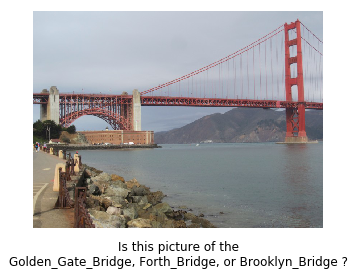

In [8]:
#plt.rcParams["font.family"] = "cursive"

def suggest_locations(img_path):
    # get landmark predictions
    Options = predict_landmarks(img_path, 3)
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title('Is this picture of the\n{}, {}, or {} ?'.format(Options[0], Options[1], Options[2]),y=-0.2)
    plt.axis('off')
    plt.show()

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ I intentionally decided to use similar category pictures (50 classes used in model training) but from different places in the world. As observed from the outputs below, the Millau bridge of France is identified as Eiffel Tower followed by Sydney harbor bridge and Forth bridge. The predictions are not accurate but at least the model is able to recognize the broad category (i.e., bridge). Similar observations can be made for other three figures. 
The outcome was expected as we have only trained the model with around 3747 samples. A large sample along with more classes would have provided a better prediction. Alternatively, we can also increase the sample size by creating multiple copies with data augmentation such as random flipping, rotation, etc.

Possible improvements:
1. Retrain the whole VGG16 model. Un-freezing the CNN layer will certainly improve the model performance. 
2. Could also include batch normalization in CNN and densely connected layers to restrict the scale of data.
3. Range of the data after normalization in my case varies from -2.7 to 2.7. Since a lot of values are below zero, leaky_RELU can be a good option. Could possibly try with different negative slope values. 

Incorporating these three in the overall model architecture may reduce the training time and improve the model performance significantly.  



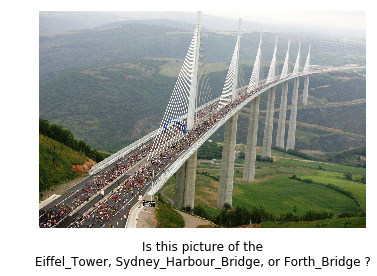

In [10]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/bridge_millau.jpg')


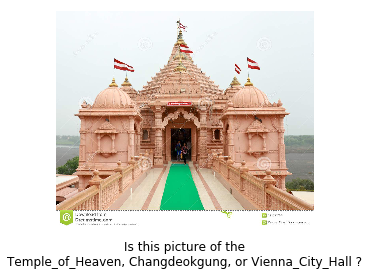

In [11]:
suggest_locations('images/hanumantempel.jpg')

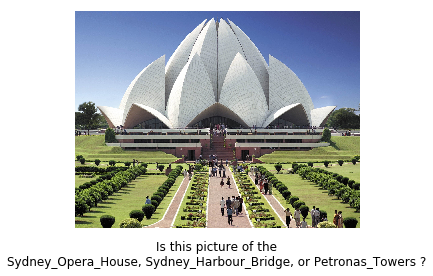

In [12]:
suggest_locations('images/Lotus_temple_india.jpg')

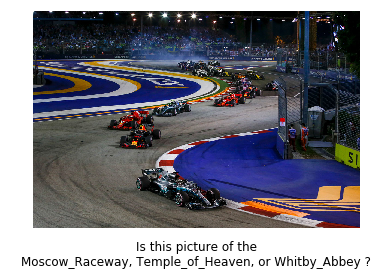

In [13]:
suggest_locations('images/racetrack_singapore.jpg')